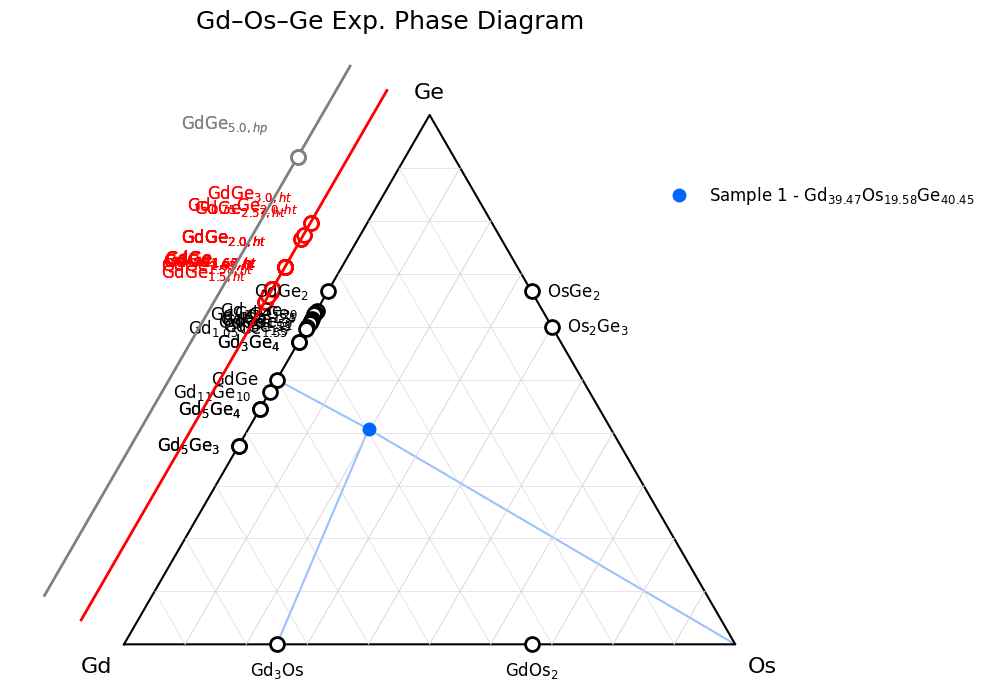

In [8]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from CifFile import ReadCif
from ipywidgets import interact, FloatSlider
import mplcursors

# --- USER ONLY NEEDS TO CHANGE THE FOLLOWING ---
ternary_elements = ['Gd', 'Os', 'Ge']  # <--- CHANGE

# --- Everything below is automatic ---

ELECTRONEGATIVITY = {
    'H': 2.20, 'He': 0, 'Li': 0.98, 'Be': 1.57, 'B': 2.04, 'C': 2.55, 'N': 3.04, 'O': 3.44,
    'F': 3.98, 'Ne': 0, 'Na': 0.93, 'Mg': 1.31, 'Al': 1.61, 'Si': 1.90, 'P': 2.19, 'S': 2.58,
    'Cl': 3.16, 'Ar': 0, 'K': 0.82, 'Ca': 1.00, 'Sc': 1.36, 'Ti': 1.54, 'V': 1.63, 'Cr': 1.66,
    'Mn': 1.55, 'Fe': 1.83, 'Co': 1.88, 'Ni': 1.91, 'Cu': 1.90, 'Zn': 1.65, 'Ga': 1.81, 'Ge': 2.3,
    'As': 2.18, 'Se': 2.55, 'Br': 2.96, 'Kr': 3.00, 'Rb': 0.82, 'Sr': 0.95, 'Y': 1.22, 'Zr': 1.33,
    'Nb': 1.6, 'Mo': 2.16, 'Tc': 1.9, 'Ru': 2.2, 'Rh': 2.28, 'Pd': 2.20, 'Ag': 1.93, 'Cd': 1.69,
    'In': 1.78, 'Sn': 1.96, 'Sb': 2.05, 'Te': 2.1, 'I': 2.66, 'Xe': 2.6, 'Cs': 0.79, 'Ba': 0.89,
    'La': 1.10, 'Ce': 1.12, 'Pr': 1.13, 'Nd': 1.14, 'Pm': 1.13, 'Sm': 1.17, 'Eu': 1.00, 'Gd': 1.20,
    'Tb': 1.10, 'Dy': 1.22, 'Ho': 1.23, 'Er': 1.24, 'Tm': 1.25, 'Yb': 1.10, 'Lu': 1.27, 'Hf': 1.3,
    'Ta': 1.5, 'W': 2.36, 'Re': 1.9, 'Os': 2.2, 'Ir': 2.20, 'Pt': 2.28, 'Au': 2.54, 'Hg': 2.00
}

mendeleev_numbers = {
    "H": 92, "He": 98, "Li": 1, "Be": 67, "B": 72, "C": 77, "N": 82, "O": 87, "F": 93, "Ne": 99,
    "Na": 2, "Mg": 68, "Al": 73, "Si": 78, "P": 83, "S": 88, "Cl": 94, "Ar": 100, "K": 3, "Ca": 7,
    "Sc": 11, "Ti": 43, "V": 46, "Cr": 49, "Mn": 52, "Fe": 55, "Co": 58, "Ni": 61, "Cu": 64, "Zn": 69,
    "Ga": 74, "Ge": 79, "As": 84, "Se": 89, "Br": 95, "Kr": 101, "Rb": 4, "Sr": 8, "Y": 12, "Zr": 44,
    "Nb": 47, "Mo": 50, "Tc": 53, "Ru": 56, "Rh": 59, "Pd": 62, "Ag": 65, "Cd": 70, "In": 75,
    "Sn": 80, "Sb": 85, "Te": 90, "I": 96, "Xe": 102, "Cs": 5, "Ba": 9, "La": 13, "Ce": 15,
    "Pr": 17, "Nd": 19, "Pm": 21, "Sm": 23, "Eu": 25, "Gd": 27, "Tb": 29, "Dy": 31, "Ho": 33,
    "Er": 35, "Tm": 37, "Yb": 39, "Lu": 41, "Hf": 45, "Ta": 48, "W": 51, "Re": 54, "Os": 57,
    "Ir": 60, "Pt": 63, "Au": 66, "Hg": 71, "Tl": 76, "Pb": 81, "Bi": 86, "Po": 91, "At": 97,
    "Rn": 103, "Fr": 6, "Ra": 10, "Ac": 14, "Th": 16, "Pa": 18, "U": 20, "Np": 22, "Pu": 24,
    "Am": 26, "Cm": 28, "Bk": 30, "Cf": 32, "Es": 34, "Fm": 36, "Md": 38, "No": 40, "Lr": 42,
}

def cif_to_dict(filepath):
    try:
        cif = ReadCif(filepath)
        first_key = list(cif.keys())[0]
        return dict(cif[first_key].items())
    except Exception as e:
        raise RuntimeError(f"Failed to parse CIF file '{filepath}': {e}")

def extract_formula(cif_dict):
    formula = cif_dict.get('_chemical_formula_sum', '').replace(" ", "").replace("'", "")
    parts = re.findall(r'([A-Z][a-z]*)([\d\.]*)', formula)
    return {elem: float(num) if num else 1.0 for elem, num in parts}

def normalize_composition(formula_dict, elements=None):
    if elements:
        total = sum(formula_dict.get(el, 0) for el in elements)
        return [formula_dict.get(el, 0) / total for el in elements] if total > 0 else None
    else:
        total = sum(formula_dict.values())
        return {k: v / total for k, v in formula_dict.items()} if total > 0 else {}

def ternary_to_cartesian(comp):
    a, b, c = comp
    x = 0.5 * (2 * b + c)
    y = (np.sqrt(3) / 2) * c
    return x, y

def format_count(count):
    if count == 1.0:
        return ""
    elif count == int(count):
        return f"_{{{int(count)}}}"
    else:
        return f"_{{{count}}}"

def sort_formula_dict_by_mendeleev(formula_dict):
    return dict(sorted(
        formula_dict.items(),
        key=lambda item: (mendeleev_numbers.get(item[0], 999), item[0])
    ))

def normalize_dict(d):
    return {k: round(v / sum(d.values()), 3) for k, v in d.items() if v > 0}

def subscript_formula_dict(formula_dict):
    label = ""
    sorted_dict = sort_formula_dict_by_mendeleev(formula_dict)
    for el, count in sorted_dict.items():
        if count == 0.0:
            continue
        label += f"\\mathrm{{{el}}}{format_count(count)}"
    return label  # No $ signs here

def draw_ternary_grid(ax, divisions=10):
    for i in range(1, divisions):
        N = divisions
        lineA, lineB, lineC = [], [], []
        for j in range(N + 1):
            if i + j <= N:
                a = i / N
                b = j / N
                c = (N - i - j) / N
                lineA.append(ternary_to_cartesian([a, b, c]))
                lineB.append(ternary_to_cartesian([b, a, c]))
                lineC.append(ternary_to_cartesian([c, a, b]))
        if len(lineA) > 1: ax.plot(*zip(*lineA), color='lightgray', lw=0.4)
        if len(lineB) > 1: ax.plot(*zip(*lineB), color='lightgray', lw=0.4)
        if len(lineC) > 1: ax.plot(*zip(*lineC), color='lightgray', lw=0.4)
    for k in range(1, divisions):
        c = k / divisions
        points = []
        for a in np.linspace(0, 1 - c, divisions + 1):
            b = 1 - c - a
            if b < 0 or b > 1:
                continue
            comp = [a, b, c]
            points.append(ternary_to_cartesian(comp))
        if len(points) > 1:
            ax.plot(*zip(*points), color='lightgray', lw=0.4)

def manual_phase_position(phase_formula, elements_order):
    parts = re.findall(r'([A-Z][a-z]*)([\d\.]*)', phase_formula)
    formula_dict = {el: float(num) if num else 1.0 for el, num in parts}
    comp = [formula_dict.get(el, 0) for el in elements_order]
    total = sum(comp)
    if total == 0:
        return None
    comp_norm = [x / total for x in comp]
    return ternary_to_cartesian(comp_norm)

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(
        c[0], 1 - amount * (1 - c[1]), c[2]
    )

def draw_parallel_dashed_line(ax, start, end, offset_vec, color='gray', lw=2, ls='-'):
    start_offset = (start[0] + offset_vec[0], start[1] + offset_vec[1])
    end_offset = (end[0] + offset_vec[0], end[1] + offset_vec[1])
    ax.plot(
        [start_offset[0], end_offset[0]],
        [start_offset[1], end_offset[1]],
        color=color, lw=lw, ls=ls, zorder=5
    )
    return start_offset, end_offset

def subscript_formula_dict_with_tag(formula_dict, tag=None):
    label = ""
    sorted_dict = sort_formula_dict_by_mendeleev(formula_dict)
    for i, (el, count) in enumerate(sorted_dict.items()):
        if count == 0.0:
            continue
        if tag and i == len(sorted_dict) - 1:
            if count == 1.0:
                label += f"\\mathrm{{{el}}}_{{{tag}}}"
            else:
                label += f"\\mathrm{{{el}}}_{{{count},{tag}}}"
        else:
            label += f"\\mathrm{{{el}}}{format_count(count)}"
    return label

def project_onto_line(x0, y0, x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1
    if dx == 0 and dy == 0:
        return x1, y1
    t = ((x0 - x1) * dx + (y0 - y1) * dy) / (dx * dx + dy * dy)
    x_proj = x1 + t * dx
    y_proj = y1 + t * dy
    return x_proj, y_proj

def main_plot(
    left_x_offset=-0.03, left_y_offset=0,
    right_x_offset=0.025, right_y_offset=0,
    bottom_x_offset=0, bottom_y_offset=-0.06,
    left_spacing=0.0, right_spacing=0.0, bottom_spacing=0.0
):
    # Dynamically build folders dict (handles both orders)
    folders = {}
    for i in range(3):
        for j in range(i + 1, 3):
            el1, el2 = ternary_elements[i], ternary_elements[j]
            folder1 = f"/Users/emiljaffal/Desktop/Gd-Os-X/CIFs/{el1}-{el2}" # <--- CHANGE
            folder2 = f"/Users/emiljaffal/Desktop/Gd-Os-X/CIFs/{el2}-{el1}" # <--- CHANGE
            # Prefer folder1 if it exists, else folder2, else None
            if os.path.exists(folder1):
                folder_path = folder1
            elif os.path.exists(folder2):
                folder_path = folder2
            else:
                folder_path = None
            folders[(el1, el2)] = folder_path
            folders[(el2, el1)] = folder_path
    
    # Only check each unique folder path once
    checked_folders = set()
    for (el1, el2), folder in folders.items():
        if folder is None or folder in checked_folders:
            continue
        checked_folders.add(folder)
        if not os.path.exists(folder):
            print(f"Folder {folder} not found.")
            continue

    formulas = {}
    unique_keys = set()
    formula_dicts = []

    # --- NEW: Collect "ht"/"hp" CIFs for bottom plotting ---
    ht_hp_cifs = []
    ht_cifs_edge = []
    hp_cifs_edge = []

    # Sort by EN for plotting order
    en_sorted = sorted(ternary_elements, key=lambda e: ELECTRONEGATIVITY.get(e, 0))
    left, right, top = en_sorted

    for (el1, el2), folder in folders.items():
        if not os.path.exists(folder):
            print(f"Folder {folder} not found.")
            continue
        for fname in os.listdir(folder):
            if fname.endswith('.cif'):
                path = os.path.join(folder, fname)
                try:
                    with open(path, 'r') as f:
                        lines = f.readlines()
                        if len(lines) >= 3:
                            line3 = lines[2].lower()
                            if 'ht' in line3 or 'hp' in line3:
                                cif_data = cif_to_dict(path)
                                formula_dict = extract_formula(cif_data)
                                ht_hp_cifs.append((fname, formula_dict, line3.strip()))
                                # For left-top edge, collect separately for parallel lines
                                if set([el1, el2]) == set([left, top]):
                                    if 'ht' in line3:
                                        ht_cifs_edge.append((fname, formula_dict, line3.strip()))
                                    if 'hp' in line3:
                                        hp_cifs_edge.append((fname, formula_dict, line3.strip()))
                                continue

                    cif_data = cif_to_dict(path)
                    formula_dict = extract_formula(cif_data)
                    norm_formula = normalize_composition(formula_dict)
                    formula_dicts.append(formula_dict)
                    structure_type = cif_data.get('_chemical_name_structure_type', '').replace(" ", "").lower()

                    identity_key = (structure_type, frozenset(norm_formula.items()))
                    if identity_key in unique_keys:
                        continue
                    unique_keys.add(identity_key)

                    binary_comp = {el: formula_dict.get(el, 0) for el in (el1, el2)}
                    for el in ternary_elements:
                        if el not in binary_comp:
                            binary_comp[el] = 0.0

                    formulas[f"{fname} ({el1}-{el2})"] = binary_comp

                except Exception as e:
                    print(f"⚠️ Failed to parse {fname} in {folder}: {e}")

    # Define pure CIF storage BEFORE plotting samples
    pure_cifs = {el: None for el in ternary_elements}
    for folder in folders.values():
        if not os.path.exists(folder):
            continue
        for fname in os.listdir(folder):
            if fname.endswith('.cif'):
                path = os.path.join(folder, fname)
                try:
                    cif_data = cif_to_dict(path)
                    formula_dict = extract_formula(cif_data)
                    if len(formula_dict) == 1:
                        elem = list(formula_dict.keys())[0]
                        if elem in pure_cifs:
                            pure_cifs[elem] = (fname, formula_dict)
                except Exception as e:
                    print(f"⚠️ Skipping {fname}: {e}")

    # Corner coordinates (EN order: left, right, top)
    corner_coords = {
        left: (0, 0),
        right: (1, 0),
        top: (0.5, np.sqrt(3) / 2),
    }

    # EDX samples: update keys to match ternary_elements
    edx_samples = [ # <--- CHANGE
        {
            "label": "Sample 1",
            "composition": {el: val for el, val in zip(ternary_elements, [39.47, 19.58, 40.45])}, # <--- CHANGE - elements A, B, C from above
            "color": "#0066FF",
            "edge_color": "#003399",
            "arrow": True,
            "phases": ["GdGe", "Gd3Os", "Os"],
        },
    ]

    fig, ax = plt.subplots(figsize=(13, 7))
    triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3) / 2], [0, 0]])
    ax.plot(triangle[:, 0], triangle[:, 1], 'k')
    draw_ternary_grid(ax)

    # --- Draw parallel dashed lines for left-top edge ---
    edge_start = corner_coords[left]
    edge_end = corner_coords[top]
    offset_ht = (-0.07, 0.04)
    offset_hp = (-0.13, 0.08)

    ht_line_start, ht_line_end = draw_parallel_dashed_line(ax, edge_start, edge_end, offset_ht, color='red', lw=2, ls='-')
    hp_line_start, hp_line_end = draw_parallel_dashed_line(ax, edge_start, edge_end, offset_hp, color='grey', lw=2, ls='-')

    # --- Place ht/hp dots and labels on dashed lines ---
    for fname, formula_dict, line3 in hp_cifs_edge:
        label = subscript_formula_dict_with_tag(formula_dict, tag="hp")
        comp = normalize_composition(formula_dict, [left, right, top])
        x, y = ternary_to_cartesian(comp)
        x_proj, y_proj = project_onto_line(x, y, hp_line_start[0], hp_line_start[1], hp_line_end[0], hp_line_end[1])
        ax.plot(x_proj, y_proj, 'o', markersize=10, markerfacecolor='white', markeredgecolor='grey', markeredgewidth=2, zorder=20)
        ax.text(x_proj - 0.12, y_proj + 0.03, f"${label}$", ha='center', va='bottom', fontsize=12, color='grey')

    for fname, formula_dict, line3 in ht_cifs_edge:
        label = subscript_formula_dict_with_tag(formula_dict, tag="ht")
        comp = normalize_composition(formula_dict, [left, right, top])
        x, y = ternary_to_cartesian(comp)
        x_proj, y_proj = project_onto_line(x, y, ht_line_start[0], ht_line_start[1], ht_line_end[0], ht_line_end[1])
        ax.plot(x_proj, y_proj, 'o', markersize=10, markerfacecolor='white', markeredgecolor='red', markeredgewidth=2, zorder=0)
        ax.text(x_proj - 0.1, y_proj + 0.03, f"${label}$", ha='center', va='bottom', fontsize=12, color='red')

    edge_groups = {
        frozenset([left, right]): [],
        frozenset([right, top]): [],
        frozenset([top, left]): [],
    }

    cif_positions = {}
    formula_compositions = []

    for formula, comp_dict in formulas.items():
        comp = normalize_composition(comp_dict, [left, right, top])
        if comp:
            x, y = ternary_to_cartesian(comp)
            cif_positions[formula] = (x, y)
            nonzero_dict = {el: comp_dict[el] for el in comp_dict if comp_dict[el] > 0}
            sorted_dict = sort_formula_dict_by_mendeleev(nonzero_dict)
            formula_compositions.append((formula, sorted_dict))
            present_elements = [el for el in comp_dict if comp_dict[el] > 0]
            key = frozenset(present_elements)
            if key in edge_groups:
                edge_groups[key].append((formula, (x, y), nonzero_dict))

    offsets = {
        frozenset([left, right]): (0, -0.06, 0.0),
        frozenset([right, top]): (0.025, 0, 0.0),
        frozenset([top, left]): (-0.03, 0, 0.0),
    }

    for edge_key, formulas_list in edge_groups.items():
        base_dx, base_dy, spacing = offsets[edge_key]
        if edge_key == frozenset([left, right]):
            formulas_list.sort(key=lambda t: t[1][0])
            for i, (formula, (x, y), nonzero_dict) in enumerate(formulas_list):
                label = subscript_formula_dict(nonzero_dict)
                dx = base_dx + i * spacing
                dy = base_dy
                ax.plot(x, y, 'o', markersize=10, markerfacecolor='white', markeredgecolor='black', markeredgewidth=2)
                ax.text(x + dx, y + dy, f"${label}$", ha='center', va='bottom', fontsize=12)
        elif edge_key == frozenset([right, top]):
            formulas_list.sort(key=lambda t: t[1][1])
            for i, (formula, (x, y), nonzero_dict) in enumerate(formulas_list):
                label = subscript_formula_dict(nonzero_dict)
                dx = base_dx
                dy = base_dy + i * spacing
                ax.plot(x, y, 'o', markersize=10, markerfacecolor='white', markeredgecolor='black', markeredgewidth=2)
                ax.text(x + dx, y + dy, f"${label}$", ha='left', va='center', fontsize=12)
        elif edge_key == frozenset([top, left]):
            formulas_list.sort(key=lambda t: -t[1][1])
            for i, (formula, (x, y), nonzero_dict) in enumerate(formulas_list):
                label = subscript_formula_dict(nonzero_dict)
                dx = base_dx
                dy = base_dy - i * spacing
                ax.plot(x, y, 'o', markersize=10, markerfacecolor='white', markeredgecolor='black', markeredgewidth=2)
                ax.text(x + dx, y + dy, f"${label}$", ha='right', va='center', fontsize=12)

    # --- Plot EDX samples ---
    used_labels = set()
    for sample in edx_samples:
        comp_list = [sample['composition'].get(el, 0) for el in [left, right, top]]
        total = sum(comp_list)
        if total == 0:
            print(f"⚠️ Sample {sample['label']} composition has zero total.")
            continue
        comp = [x / total for x in comp_list]
        sx, sy = ternary_to_cartesian(comp)
        legend_label = f"{sample['label']} - ${subscript_formula_dict(sample['composition'])}$"
        plot_kwargs = dict(
            markersize=10,
            markerfacecolor=sample['color'],
            markeredgecolor='none'
        )
        if legend_label not in used_labels:
            plot_kwargs['label'] = legend_label
            used_labels.add(legend_label)
        ax.plot(sx, sy, 'o', **plot_kwargs)

        for phase_name in sample['phases']:
            phase_dict = extract_formula({'_chemical_formula_sum': phase_name})
            phase_dict_sorted = sort_formula_dict_by_mendeleev(phase_dict)
            norm_phase_dict = normalize_dict(phase_dict_sorted)
            matched = False
            for formula, comp_dict in formula_compositions:
                comp_dict_sorted = sort_formula_dict_by_mendeleev(comp_dict)
                norm_formula_dict = normalize_dict(comp_dict_sorted)
                if norm_phase_dict == norm_formula_dict:
                    px, py = cif_positions[formula]
                    ax.plot([sx, px], [sy, py], color=sample['color'], linewidth=1.5, zorder=1, alpha=0.4, linestyle='-')
                    matched = True
                    break
            if not matched:
                pos = manual_phase_position(phase_name, [left, right, top])
                if pos:
                    px, py = pos
                    ax.plot(
                        px, py, 'o', markersize=10,
                        color='white',
                        markeredgecolor='black',
                        markeredgewidth=2,
                        zorder=2
                    )
                    is_pure = len(phase_dict_sorted) == 1
                    if not is_pure:
                        ax.text(px + 0.02 , py + 0.02, f"${subscript_formula_dict(phase_dict)}$", ha='center', va='bottom', fontsize=12, color='black')
                    ax.plot(
                        [sx, px], [sy, py],
                        color=sample['color'],
                        linewidth=1.5,
                        linestyle='-',
                        zorder=1,
                        alpha=0.5,
                    )

    label_offset = 0.02
    ax.text(corner_coords[left][0] - label_offset, corner_coords[left][1] - label_offset, left, ha='right', va='top', fontsize=16, color='black')
    ax.text(corner_coords[right][0] + label_offset, corner_coords[right][1] - label_offset, right, ha='left', va='top', fontsize=16)
    ax.text(corner_coords[top][0], corner_coords[top][1] + label_offset, top, ha='center', va='bottom', fontsize=16)

    ax.set_aspect('equal')
    ax.set_axis_off()
    ax.set_title(f"{'–'.join(ternary_elements)} Exp. Phase Diagram", fontsize=18)
    handles, labels = ax.get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    ax.legend(
        unique.values(), unique.keys(),
        loc='center left',
        bbox_to_anchor=(.85, 0.75),
        fontsize=12,
        frameon=False,
        borderaxespad=0,
        title_fontsize=14
    )
    plt.subplots_adjust(right=0.75)
    plt.tight_layout()
    plt.savefig("/Users/emiljaffal/Downloads/ternary_plot.png", dpi=300, bbox_inches='tight') # <--- CHANGE
    plt.show()

# Call the plot function
main_plot()